In [3]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
#import NLTE.NLTE_model_17sep as NLTE.NLTE_model

import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.physical_models import BlackBody
from scipy.interpolate import interp1d


environments = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
                NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.190, line_velocity= 0.190, t_d=3.41)]

#(0.6e8*4.4**-3) * (0.20/0.30)**-5 / 1e7

In [4]:
## First we illustrate how to see the relative populations change in time

[<NLTE.NLTE_model.CollisionProcess object at 0x7fd138dadf70>, <NLTE.NLTE_model.RadiativeProcess object at 0x7fd138dadca0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7fd138dcc370>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7fd10b8b8e50>]
2.8220668717332263e-06
[<NLTE.NLTE_model.CollisionProcess object at 0x7fd10bc69160>, <NLTE.NLTE_model.RadiativeProcess object at 0x7fd10bbed460>, <NLTE.NLTE_model.RecombinationProcess object at 0x7fd10bc69a60>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7fd10bc69f70>]
0.00010885940108367538


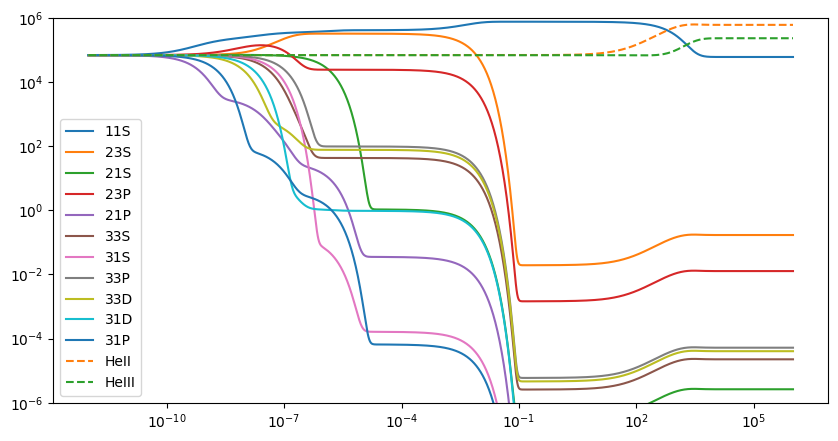

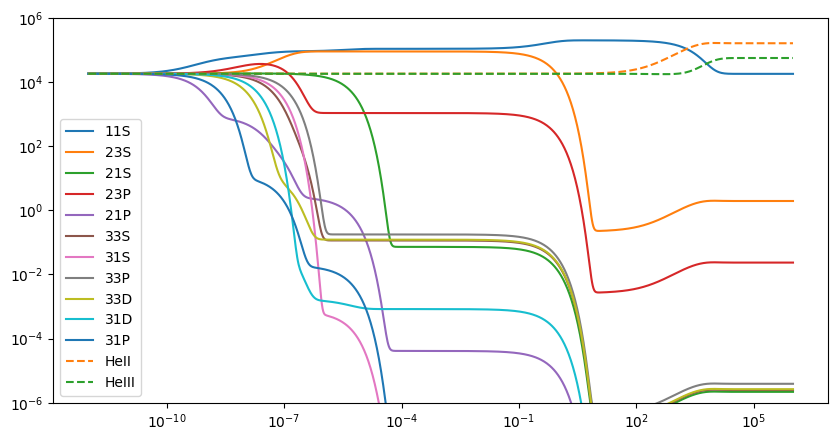

In [5]:
states = NLTE.NLTE_model.States()
for environment in environments:
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    print(nlte_solver.processes)
    t, y = nlte_solver.solve(np.geomspace(1e-12,1000000, 1000))
    plt.figure(figsize=(10,5))
    plt.plot(t, y.T[:, :-2], label = states.names);
    plt.plot(t, y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"]);
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-6, 1e6)
    plt.legend()
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)
    
    print( (y.T[:, 1]/y.T[:, 0])[-1] )

In [6]:
## Next we will solve a simple Mock_System

T_arr = np.linspace(2300, 7000, 20 )
varr = 0.31*np.ones_like(T_arr)
tarr = 1.2*np.ones_like(T_arr)
parameters = [{"T_phot": T, "photosphere_velocity": v, "t_d": t} for T,v,t in zip(T_arr, varr, tarr)
             ]# TODO: rest
density_table = []

i_arr = [1, 1, 1, 1, 1, 1]

def fit_tau_v(v, tau0, ve): 
    return tau0 * np.exp(-v/ve)
c_arr = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

dens0 = []
mass0 = []
for params in parameters:
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 25)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        #nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    
    dens0.append( densities[0,1] ) 
    
    tau_at_layer = densities[:,1]/(7.4*params["t_d"]**-1)
    nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * np.sum(densities[:,:], axis=1) ), 
         velocities*3e10*params["t_d"]*24*3600 
         )
    
    mass0.append( nHe*(6.646e-27)/2e30 * 4.04/tau_at_layer[0] )

In [22]:
np.array( [0.30, 0.27793590677592556, 0.24759563525437875, 0.2040532752198964, 0.17252131613287214] ) + 0.021

array([0.321     , 0.29893591, 0.26859564, 0.22505328, 0.19352132])

0.0028413268291909094
0.0028413268291909094
0.0040228894927649755
0.00616800740514668
0.00980170220898836


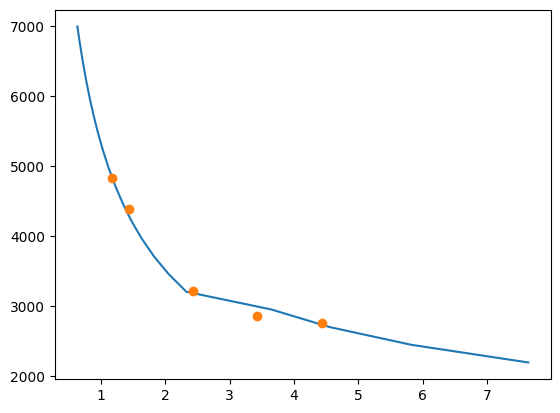

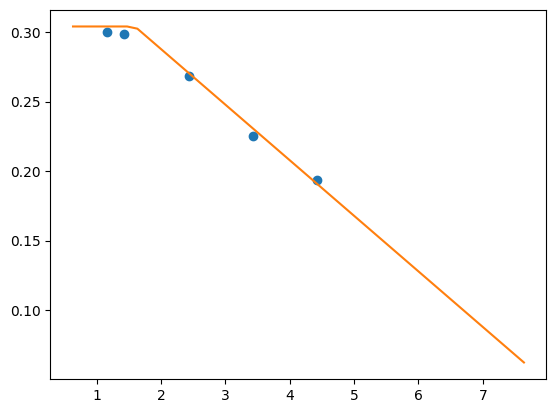

In [25]:
## Next we will show the evolution in parameters expected for AT2017gfo from fitting the feature and continuum
T_arr = np.linspace(2200, 7000, 20 )
tarr = np.zeros_like(T_arr)
tarr[T_arr>3200] = 1.43*(T_arr[T_arr>3200]/4300)**(-1/0.60)
tarr[T_arr<3200] = 1.43*(T_arr[T_arr<3200]/4300)**(-1/0.4)

plt.plot(tarr, T_arr)

n_days = [1.17, 1.43, 2.43, 3.43, 4.43]
vn = [0.30     , 0.29893591, 0.26859564, 0.22505328, 0.19352132]
tn = [5989.442056587274, 5440.8967947121055, 3935.619453803755, 3419.5184704387616, 3229.356686107796]
plt.plot(n_days, tn/(1+np.array(vn))/np.sqrt(1-np.array(vn)**2), "o")

plt.figure()
varr = 0.321 - 0.040*(tarr-1.17) # Offset
varr[tarr<1.50] = (0.304)*np.ones_like(varr[tarr<1.50])

#varr = 0.28* (tarr/1.43)**(-0.39)

plt.plot(n_days, np.array(vn), "o")
plt.plot(tarr, varr)

#plt.plot()
#print(varr)

#arr_v_phot = interp1d(tarr, varr)(n_days) 
#print(arr_v_phot)


v = np.linspace(0.1, 0.5, 10000)
rho_ejecta = (10) * (v/0.30)**-5
tot_mass = 0.04 / np.trapz(rho_ejecta * v**2, v)

rho_ejecta_scaled = tot_mass * rho_ejecta
tot_mass_arr = []

for vi in arr_v_phot: 
    print( np.trapz( (rho_ejecta_scaled*v**2)[v>vi], v[v>vi]) )
    tot_mass_arr.append(np.trapz( (rho_ejecta_scaled*v**2)[v>vi], v[v>vi]))

In [31]:
#Mass with photoionisation

parameters = [{"T_phot": T, "photosphere_velocity": v, "t_d": t} for T,v,t in zip(T_arr, varr, tarr)
             ]
density_table = []

i_arr = [1, 1, 1, 1, 1, 1]

def fit_tau_v(v, tau0, ve): 
    return tau0 * np.exp(-v/ve)
c_arr = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

dens0 = []
mass0_with_photoionisation = []
for params in parameters:
#for params in parameters[:5]:
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 25)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        #nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    
    dens0.append( densities[0,1] ) 
    
    tau_at_layer = densities[:,1]/(7.4*params["t_d"]**-1)
    #nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * densities[:,-2]),# * np.sum(densities[:,:], axis=1) ), 
    
    nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * np.sum(densities[:,:], axis=1) ), 
         velocities*3e10*params["t_d"]*24*3600 
         )
    
    nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * np.sum(densities[:,:], axis=1) ), 
         velocities*3e10*params["t_d"]*24*3600 
         )
    
    #nHeII = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * densities[:,-2] ), 
    #     velocities*3e10*params["t_d"]*24*3600 
    #     )
    
    mass0_with_photoionisation.append( nHe*(6.646e-27)/2e30 * 4.04/tau_at_layer[0] )

In [32]:
## Code for finding mass density in different shells
power = 7

velocities_n = np.linspace(0.1, 0.5, 100)
densities_n = (velocities_n)**(-power)

tot = np.trapz( (4 * np.pi * (velocities_n*3e10*params["t_d"]*24*3600 )**2 * densities_n ), 
                   # densities[:,-2]
         velocities_n*3e10*params["t_d"]*24*3600)

velocities_n = np.linspace(0.15, 0.5, 100)
densities_n = (velocities_n)**(-power)

tot2 = np.trapz( (4 * np.pi * (velocities_n*3e10*params["t_d"]*24*3600 )**2 * densities_n ), 
                   # densities[:,-2]
         velocities_n*3e10*params["t_d"]*24*3600)

print(tot2/tot)

0.19589462080215253


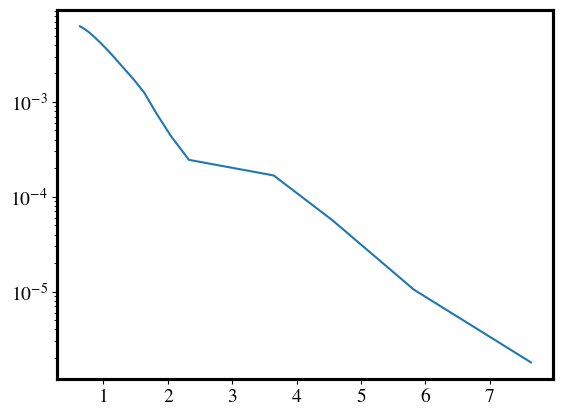

In [33]:
#plt.plot( mass0_with_photoionisation/4.04 ), 
#tau_at_layer[0]
tarr, np.array( mass0_with_photoionisation )/4.04

plt.plot( tarr, np.array( mass0_with_photoionisation )/4.04 )
plt.yscale('log')

In [34]:
## Observed tau from P Cygni fits

tau_list = np.ones_like( np.array([4.04, 1.23, 1.25, 1.4, 0.86, 0.4]) )
tau_list_err = np.array([0.70, 0.1946, 0.1258, 0.04173, 0.018, 0.018])

tau_list = np.array([4.04, 1.23, 1.25, 1.4, 0.86, 0.5]) 
i_ratio = tau_list/tau_list[0]

rel_err = np.array([1/3.03, 1/4.09, 1/10, 1/36, 1/54, 1/54])#tau_list_err/tau_list

0.92 0.0030641691460235
 
1.17 0.012256676584094 0.004217866366632087
0.0030641691460235
 
M_tot 0.0028413268291909094
X_he 1.2 4.313715852105682 1.4844706787332729
 
M_he 1.4 0.0019406704621931926 0.0005173396276610577
M_tot 0.0028413268291909094
X_he 1.4 0.683015569435852 0.18207677566201502
Upper_lim 1.4 1.0471691207598819
Upper_lim, 0.1 1.4 0.29753497175153076
 
M_he 2.4 0.0005291862520747523 0.0001334535810393085
M_tot 0.0040228894927649755
X_he 2.4 0.13154382018856722 0.033173563747977676
Upper_lim 2.4 0.1978909476845226
Upper_lim, 0.1 2.4 0.07960934141533693
 
M_he 3.4 0.0002956512724764467 8.444576561819411e-05
M_tot 0.00616800740514668
X_he 3.4 0.047933028133161894 0.013690931296180233
Upper_lim 3.4 0.07531489072552236
Upper_lim, 0.1 3.4 0.04645428037128349
 
M_he 4.4 0.00012234156565503606 5.189877169482837e-05
M_tot 0.00980170220898836
X_he 4.4 0.012481665229825729 0.0052948733381469335
Upper_lim 4.4 0.023071411906119596
Upper_lim, 0.1 4.4 0.022613910904469278
 


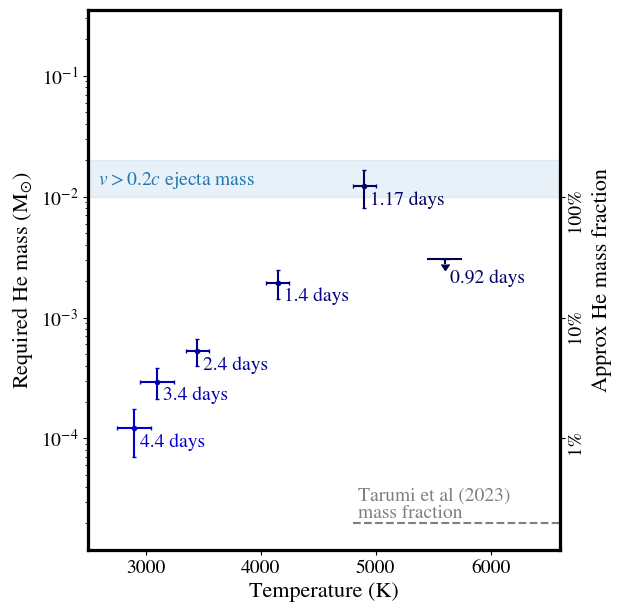

In [35]:
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = False
    plt.rcParams['grid.alpha'] = 0.6
reset_plt(14, 16)

def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

fig, ax = plt.subplots(figsize=(6.5,6.4))

mass0 = mass0_with_photoionisation
#plt.plot(T_arr, mass0, color=get_darker(0.6, [0.3, 0, 1]), label=' He II mass required \n to produce feature')
#plt.plot(T_arr, mass_Tarumi)

plt.yscale('log')
plt.ticklabel_format(axis='x', useOffset=False, style='plain')
plt.xlim(2500, 6600)
plt.ylim(1.2e-5, 0.035e0)
plt.ylabel('Required He mass (M$_{\odot})$')
plt.xlabel('Temperature (K)')

#plt.axhline(0.05, ls='--', color='grey'),
#plt.fill_between([1e3,1e4] ,[0.05, 0.05], [0.08, 0.08], color='grey', alpha=0.1)
#plt.text(2550, 0.055, 'Total ejecta mass', fontsize=14, color='grey')
#plt.axhline(0.01, ls='dotted', color='C0'), 
plt.fill_between([1e3,1e4] ,[0.01, 0.01], [0.02, 0.02], color='C0', alpha=0.1)
plt.text(2550, 0.0125, r" $v > 0.2c$ ejecta mass", color='C0', fontsize=14)
#plt.text(2550, 0.0105, r" component's mass", color='C0', fontsize=14)
#plt.axhline(0.01*1e-2, ls='-', color='darkblue'), 

#plt.fill_between([1e3,1e4] ,[0.0, 0.0], [1.5e-4, 1.5e-4], color='darkred', alpha=0.1)
#plt.plot(np.array([4.8e3,1e4]), np.array([1.0e-4, 1.0e-4]), color='darkred', alpha=0.7, ls='--')
#plt.text(4850, 1.58e-4, r"$\alpha$-particles upper limit", fontsize=14, color='darkred', alpha=0.7)
#plt.text(4850, 1.13e-4, r"from heavy nuclei decay", fontsize=14, color='darkred', alpha=0.7)
#plt.text(5350, 0.48e-4, r"of ", fontsize=14, color='darkred')

#make dark orange 

plt.axhline(2e-5, xmin=0.562, ls='--', alpha=0.5, color='k')#color=get_darker(0.4, [1, 0.5, 0]), alpha=0.6)   
plt.text(4850, 2.2e-5*1.4, r"Tarumi et al (2023)", fontsize=14, alpha=0.5, color='k') #color=get_darker(0.4, [1, 0.5, 0]))
plt.text(4850, 2.2e-5, r"mass fraction", fontsize=14, alpha=0.5, color='k') #color=get_darker(0.4, [1, 0.5, 0]))
#plt.axhline(2e-6, ls='--', color='darkgrey', alpha=0.6)   
#plt.text(4850, 1.25e-6, r"Perego et al (2022)", fontsize=14, color='darkgreen', alpha=0.8)
#plt.fill_between([1e3,1e4] ,[0.0, 0.0], [2e-6, 2e-6], color='darkgreen', alpha=0.2)



i1 = interp1d(T_arr, mass0)(4900)
T_swift = 6400 / (1+np.random.normal(loc=0.30, scale=0.04, size=100) )
ratio_err = np.std(interp1d(T_arr, mass0)(T_swift))
plt.errorbar(4900, i1, xerr = 100, yerr = np.sqrt(ratio_err**2 + (rel_err[0]*i1)**2 ), color=get_darker(0.4, [0, 0, 1]), capsize=1.5, fmt='.',
            )#label='He mass outside \n photosphere')
print(0.92, i1*0.25)
print(' ')
print( 1.17, i1, np.sqrt(ratio_err**2 + (rel_err[0]*i1)**2 ) )
#plt.legend(handlelength=1.3, loc=1)
#plt.text(5000-60, 2.5e-5, 'SALT + Swift', color=get_darker(0.4, [0, 0, 1]), fontsize=16, rotation=90)
#plt.fill_between([5000-100, 5000+100], [i1-ratio_err, i1+ratio_err], color=get_darker(0.4, [0, 0, 1]), alpha=0.1)
#plt.fill_between([0, 5000-100, 5000+100], [i1-ratio_err, i1-ratio_err, i1+ratio_err], [i1+ratio_err, i1+ratio_err, i1+ratio_err], 
#                 color=get_darker(0.4, [0, 0, 1]), alpha=0.1)
plt.text(4900+50, i1*0.70, str(1.17)+' days', fontsize=14, color=get_darker(0.4, [0, 0, 1]) )  

plt.errorbar([5600], [i1*0.25], xerr=[150], yerr=[i1*0.25*0.1], uplims=True, 
             fmt='_', capsize=0, color=get_darker(0.3, [0, 0, 1]))

#plt.plot([5600-200, 5600+200], [i1*0.225, i1*0.225], color=get_darker(0.3, [0, 0, 1]))
#plt.fill_between([5600-200, 5600+200], [i1*0.225, i1*0.225], color=get_darker(0.3, [0, 0, 1]), alpha=0.1)
plt.text(5600+50, i1*0.225*0.70, str(0.92)+' days', fontsize=14, color=get_darker(0.4, [0, 0, 1]) )  
print(i1*0.25)
print(' ')
print('M_tot', tot_mass_arr[0])
print('X_he', 1.2, i1/tot_mass_arr[0], np.sqrt(ratio_err**2 + (rel_err[0]*i1)**2 )/tot_mass_arr[0])
print(' ')
    
n_days = [1.4, 2.4, 3.4, 4.4, 5.4]
i = [0.5, 0.6, 0.7, 0.8, 0.9]
T_unc = [100, 100, 150, 150]

strength_1 = []
j = 0
for T_x1, nday, i, ratio, t_unc, rel_unc in zip([4150, 3450, 3100, 2900, 2700],n_days, i, i_ratio[1:], T_unc, rel_err[1:] ): 
    #T_x1 = 4400
    i1 = interp1d(T_arr, mass0)(T_x1)
    T_swift = np.random.normal(loc=T_x1, scale=t_unc, size=150)
    ratio_err = np.std(ratio*interp1d(T_arr, mass0)(T_swift))
    plt.errorbar(T_x1, ratio*i1, xerr = t_unc, yerr = ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2), color=get_darker(i, [0, 0, 1]), capsize=1.5, fmt='.',
                  )
    
    #plt.errorbar(T_x1, ratio*i1, xerr = t_unc, yerr = 2*((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2), 
    #             color=get_darker(i, [0, 0, 1]), capsize=1.5, fmt='.', alpha=0.5
    #              )
    
    #plt.fill_between([T_x1-80, T_x1+80], [i1-ratio_err, i1+ratio_err], color=get_darker(i, [0, 0, 1]), alpha=0.1)
    #plt.fill_between([0, T_x1-80, T_x1+80], [i1-ratio_err, i1-ratio_err, i1+ratio_err], [i1+ratio_err, i1+ratio_err, i1+ratio_err], 
    #             color=get_darker(i, [0, 0, 1]), alpha=0.1)

    print('M_he', nday, ratio*i1, ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2))

    #v = np.linspace(0.1, 0.5, 10000)
    #rho_ejecta = (10) * (v/0.30)**-5
    #tot_mass = 0.04 / np.trapz(rho_ejecta * v**2, v)

    #rho_ejecta_scaled = tot_mass * rho_ejecta
    #for vi in arr_v_phot: 
    #    tot_mass = np.trapz( (rho_ejecta_scaled*v**2)[v>vi], v[v>vi])
    print('M_tot', tot_mass_arr[j+1])
    print('X_he', nday, ratio*i1/tot_mass_arr[j+1], ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2)/tot_mass_arr[j+1])
    print('Upper_lim', nday, ratio*i1/tot_mass_arr[j+1] + 2* ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2)/tot_mass_arr[j+1])
    print('Upper_lim, 0.1', nday, ratio*i1/0.01 + 2* ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2)/0.01)
    print(' ' )
    j += 1
    #print('X_he', nday, ratio*i1/tot_mass, ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2)/tot_mass)

    strength_1.append(ratio*i1)
    plt.text(T_x1+50, ratio*i1*0.70, str(nday)+' days', fontsize=14, color=get_darker(i, [0, 0, 1]) )  


ax_new = ax.twinx()   
plt.ylim( ax.get_ylim() )
plt.yscale('log')
#plt.yticks([0.01, 1.0e-3, 1.0e-4, 1e-5], labels=['  100%', '  10%', '  1%', ' 0.1%'], rotation=90)
plt.yticks([0.01, 1.0e-3, 1.0e-4], labels=['  100%', '  10%', '  1%'], rotation=90)
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_minor_locator(plt.NullLocator())


plt.ylabel('Approx He mass fraction') 
plt.tight_layout()
#plt.savefig('He_mass_time_22sep_Ralchenko.png', dpi=300) 


In [ ]:
#0.041713476975115044+2*0.017013646794179087, 0.0311+0.014*2, 0.032101153533378446+2*0.004900478641664631

#### 

8.758454890469128 5.733963056194785
8.100692939992184 1.1830329410004352
8.061092038086496 1.151044298766576


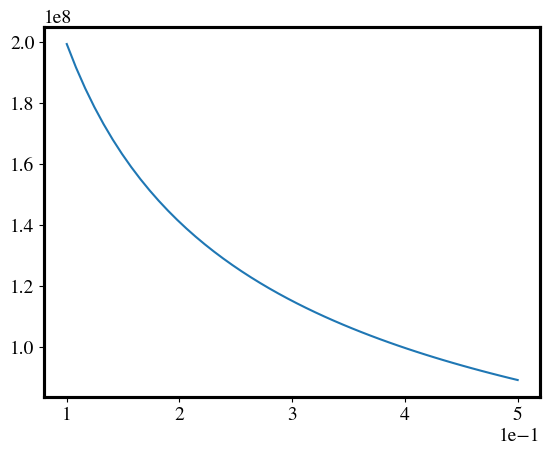

In [36]:
## realistic electron densities
M_tot = 0.08 * 2e33
w_particle = 100*1.67e-24
N_part = M_tot / w_particle #Maybe the actual percentage is more like 4%
N_electrons = N_part
td = 1
V = 4/3*np.pi* (0.284*3e10*(td*86400))**3

print( np.log10( N_electrons/V ), N_electrons/V / 1e8 )

v = np.linspace(0.1, 0.5)
r = v*3e10*86400 #r at 1 day
rho_v = v**(-0.5)
norm = 1/np.trapz(rho_v * 4*np.pi*r**2, r)
plt.plot( v, norm * rho_v * N_part )

import scipy.interpolate
print( np.log10( scipy.interpolate.interp1d(v, norm * rho_v * N_part)(0.25) ), scipy.interpolate.interp1d(v, norm * rho_v * N_part)(0.284)/1e8 )
print( np.log10( scipy.interpolate.interp1d(v, norm * rho_v * N_part)(0.30) ) , scipy.interpolate.interp1d(v, norm * rho_v * N_part)(0.30)/1e8 )

In [ ]:
### Not neccesary to execute

parameters = [{"T_phot": T, "photosphere_velocity": v, "t_d": t} for T,v,t in zip(T_arr, varr, tarr)]
density_table = []

i_arr = [1, 1, 1, 1, 1, 1]

def fit_tau_v(v, tau0, ve): 
    return tau0 * np.exp(-v/ve)
c_arr = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

mass_Tarumi = []
for params in parameters:
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 25)
    densities = []
    for v in velocities:
        #states = NLTE.NLTE_model.States().filter(["11S", "23S", "21S", "23P", "21P"])
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
        #nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    
    dens0.append( densities[0,1] ) 
    
    tau_at_layer = densities[:,1]/(7.4*params["t_d"]**-1)
#    nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * densities[:,-2]),#np.sum(densities[:,:], axis=1) ), 
    nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * np.sum(densities[:,:], axis=1) ), 
         velocities*3e10*params["t_d"]*24*3600 
         )
    
    mass_Tarumi.append( nHe*(6.646e-27)/2e30 * 4.04/tau_at_layer[0] )
    


1.17 0.012256676584094 0.004253453957902205
0.0030641691460235
1.4 0.0019406704621931926 0.0005377597410854676
2.4 0.0005291862520747523 0.00012698963307789446
3.4 0.0002956512724764467 8.729696286572007e-05
4.4 0.00012234156565503606 5.030390037653717e-05
5.4 2.7822307496426643e-05 2.274772955123331e-05


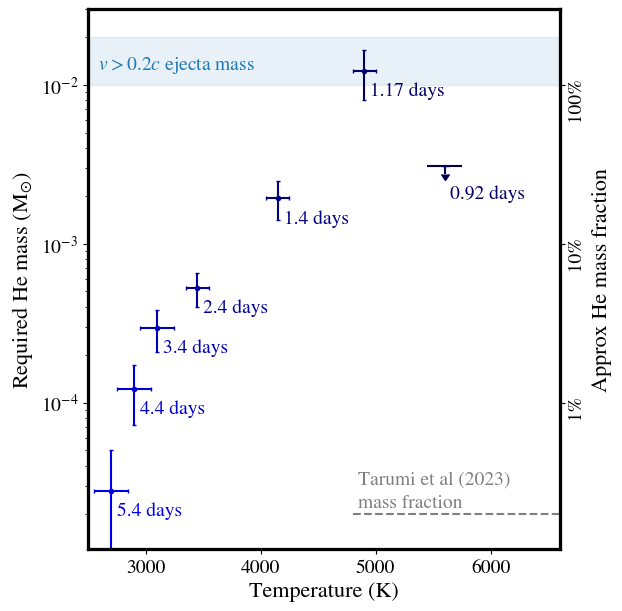

In [37]:
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = False
    plt.rcParams['grid.alpha'] = 0.6
reset_plt(14, 16)

def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

fig, ax = plt.subplots(figsize=(6.5,6.4))

mass0 = mass0_with_photoionisation
#plt.plot(T_arr, mass0, color=get_darker(0.6, [0.3, 0, 1]), label=' He II mass required \n to produce feature')
#plt.plot(T_arr, mass_Tarumi)

plt.yscale('log')
plt.ticklabel_format(axis='x', useOffset=False, style='plain')
plt.xlim(2500, 6600)
plt.ylim(1.2e-5, 0.03e0)
plt.ylabel('Required He mass (M$_{\odot})$')
plt.xlabel('Temperature (K)')

#plt.axhline(0.05, ls='--', color='grey'),
#plt.fill_between([1e3,1e4] ,[0.05, 0.05], [0.08, 0.08], color='grey', alpha=0.1)
#plt.text(2550, 0.055, 'Total ejecta mass', fontsize=14, color='grey')
#plt.axhline(0.01, ls='dotted', color='C0'), 
plt.fill_between([1e3,1e4] ,[0.01, 0.01], [0.02, 0.02], color='C0', alpha=0.1)
plt.text(2550, 0.0125, r" $v > 0.2c$ ejecta mass", color='C0', fontsize=14)
#plt.text(2550, 0.0105, r" component's mass", color='C0', fontsize=14)
#plt.axhline(0.01*1e-2, ls='-', color='darkblue'), 

#plt.fill_between([1e3,1e4] ,[0.0, 0.0], [1.5e-4, 1.5e-4], color='darkred', alpha=0.1)
#plt.plot(np.array([4.8e3,1e4]), np.array([1.0e-4, 1.0e-4]), color='darkred', alpha=0.7, ls='--')
#plt.text(4850, 1.58e-4, r"$\alpha$-particles upper limit", fontsize=14, color='darkred', alpha=0.7)
#plt.text(4850, 1.13e-4, r"from heavy nuclei decay", fontsize=14, color='darkred', alpha=0.7)
#plt.text(5350, 0.48e-4, r"of ", fontsize=14, color='darkred')

#make dark orange 

plt.axhline(2e-5, xmin=0.562, ls='--', alpha=0.5, color='k')#color=get_darker(0.4, [1, 0.5, 0]), alpha=0.6)   
plt.text(4850, 2.2e-5*1.4, r"Tarumi et al (2023)", fontsize=14, alpha=0.5, color='k') #color=get_darker(0.4, [1, 0.5, 0]))
plt.text(4850, 2.2e-5, r"mass fraction", fontsize=14, alpha=0.5, color='k') #color=get_darker(0.4, [1, 0.5, 0]))
#plt.axhline(2e-6, ls='--', color='darkgrey', alpha=0.6)   
#plt.text(4850, 1.25e-6, r"Perego et al (2022)", fontsize=14, color='darkgreen', alpha=0.8)
#plt.fill_between([1e3,1e4] ,[0.0, 0.0], [2e-6, 2e-6], color='darkgreen', alpha=0.2)



from scipy.interpolate import interp1d
i1 = interp1d(T_arr, mass0)(4900)
T_swift = 6400 / (1+np.random.normal(loc=0.30, scale=0.04, size=100) )
ratio_err = np.std(interp1d(T_arr, mass0)(T_swift))
plt.errorbar(4900, i1, xerr = 100, yerr = np.sqrt(ratio_err**2 + (rel_err[0]*i1)**2 ), color=get_darker(0.4, [0, 0, 1]), capsize=1.5, fmt='.',
            )#label='He mass outside \n photosphere')
print( 1.17, i1, np.sqrt(ratio_err**2 + (rel_err[0]*i1)**2 ) )
#plt.legend(handlelength=1.3, loc=1)
#plt.text(5000-60, 2.5e-5, 'SALT + Swift', color=get_darker(0.4, [0, 0, 1]), fontsize=16, rotation=90)
#plt.fill_between([5000-100, 5000+100], [i1-ratio_err, i1+ratio_err], color=get_darker(0.4, [0, 0, 1]), alpha=0.1)
#plt.fill_between([0, 5000-100, 5000+100], [i1-ratio_err, i1-ratio_err, i1+ratio_err], [i1+ratio_err, i1+ratio_err, i1+ratio_err], 
#                 color=get_darker(0.4, [0, 0, 1]), alpha=0.1)
plt.text(4900+50, i1*0.70, str(1.17)+' days', fontsize=14, color=get_darker(0.4, [0, 0, 1]) )  

plt.errorbar([5600], [i1*0.25], xerr=[150], yerr=[i1*0.25*0.1], uplims=True, 
             fmt='_', capsize=0, color=get_darker(0.3, [0, 0, 1]))

#plt.plot([5600-200, 5600+200], [i1*0.225, i1*0.225], color=get_darker(0.3, [0, 0, 1]))
#plt.fill_between([5600-200, 5600+200], [i1*0.225, i1*0.225], color=get_darker(0.3, [0, 0, 1]), alpha=0.1)
plt.text(5600+50, i1*0.225*0.70, str(0.92)+' days', fontsize=14, color=get_darker(0.4, [0, 0, 1]) )  
print(i1*0.25)

n_days = [1.4, 2.4, 3.4, 4.4, 5.4]
i = [0.5, 0.6, 0.7, 0.8, 0.9]
T_unc = [100, 100, 150, 150, 150]
for T_x1, nday, i, ratio, t_unc, rel_unc in zip([4150, 3450, 3100, 2900, 2700],n_days, i, i_ratio[1:], T_unc, rel_err[1:] ): 
    #T_x1 = 4400
    i1 = interp1d(T_arr, mass0)(T_x1)
    T_swift = np.random.normal(loc=T_x1, scale=t_unc, size=150)
    ratio_err = np.std(ratio*interp1d(T_arr, mass0)(T_swift))
    plt.errorbar(T_x1, ratio*i1, xerr = t_unc, yerr = ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2), color=get_darker(i, [0, 0, 1]), capsize=1.5, fmt='.',
                  )
    
    #plt.fill_between([T_x1-80, T_x1+80], [i1-ratio_err, i1+ratio_err], color=get_darker(i, [0, 0, 1]), alpha=0.1)
    #plt.fill_between([0, T_x1-80, T_x1+80], [i1-ratio_err, i1-ratio_err, i1+ratio_err], [i1+ratio_err, i1+ratio_err, i1+ratio_err], 
    #             color=get_darker(i, [0, 0, 1]), alpha=0.1)

    print(nday, ratio*i1, ((ratio_err)**2+(rel_unc*ratio*i1)**2)**(1/2))
    
    plt.text(T_x1+50, ratio*i1*0.70, str(nday)+' days', fontsize=14, color=get_darker(i, [0, 0, 1]) )  


ax_new = ax.twinx()   
plt.ylim( ax.get_ylim() )
plt.yscale('log')
#plt.yticks([0.01, 1.0e-3, 1.0e-4, 1e-5], labels=['  100%', '  10%', '  1%', ' 0.1%'], rotation=90)
plt.yticks([0.01, 1.0e-3, 1.0e-4], labels=['  100%', '  10%', '  1%'], rotation=90)
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_minor_locator(plt.NullLocator())


#plt.set_ticks() 
plt.ylabel('Approx He mass fraction')
plt.tight_layout()
#plt.savefig('He_mass_time_3.png', dpi=300) 

In [38]:
mu0, sig0 = 0.011947628804866363, 0.004620081824766842
mu1, sig1 = 0.001202932280490148,  0.0003644258691963611
mu2, sig2 = 0.00029503870698035877, 7.18388645328795e-05
mu3, sig3 = 0.00018386082181299682, 5.9419192865432936e-05
mu4, sig4 = 7.809418482224852e-05, 2.8285382489043186e-05
mu5, sig5 = 2.0038959065269923e-05, 1.3548190399903277e-05

a1, a2 = np.random.normal(mu0, sig0, size = 100000), np.random.normal(mu4, sig4, size = 100000)
delta_m = (a1-a2)/a1
print( np.mean(delta_m), np.std(delta_m) )

a1, a2 = np.random.normal(mu1, sig1, size = 1000), np.random.normal(mu4, sig4, size = 1000)
delta_m = (a1-a2)/a1
print( np.mean(delta_m), np.std(delta_m) )

a1, a2 = np.random.normal(mu2, sig2, size = 1000), np.random.normal(mu4, sig4, size = 1000)
delta_m = (a1-a2)/a1
print( np.mean(delta_m)-2*np.std(delta_m), np.std(delta_m) )

a1, a2 = np.random.normal(mu3, sig3, size = 1000), np.random.normal(mu4, sig4, size = 1000)
delta_m = (a1-a2)/a1
print( np.mean(delta_m), np.std(delta_m) )

print(mu4 + sig4*5)

0.9895548688839989 0.3126373651521618
0.9152462395580937 0.3610531114657427
0.3985883510452177 0.15798128101738912
0.5247903531049887 0.4166508321942712
0.00021952109726746446


## To infer optical depth at different times versus fits

In [ ]:
from scipy.optimize import curve_fit
parameters = [{"T_phot": 5800, "photosphere_velocity": 0.3, "t_d": 0.92},
              {"T_phot": 5000, "photosphere_velocity": 0.3, "t_d": 1.18},
              {"T_phot": 4400, "photosphere_velocity": 0.28, "t_d": 1.4},
              {"T_phot": 3450, "photosphere_velocity": 0.25, "t_d": 2.4},
              {"T_phot": 3100, "photosphere_velocity": 0.21, "t_d": 3.4},
              {"T_phot": 2900, "photosphere_velocity": 0.18, "t_d": 4.4},
              ]# TODO: rest
density_table = []

i_arr = [1, 1, 1, 1, 1, 1]

def fit_tau_v(v, tau0, ve): 
    return tau0 * np.exp(-v/ve)
c_arr = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for i, color, params in zip(i_arr, c_arr, parameters):
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 25)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    plt.plot(velocities, densities[:,1]/(7.4*params["t_d"]**-1) * (0.002/0.002), label = params["t_d"], 
            color = color);
    plt.yscale("log")
    plt.axhline(1, linestyle="--", color="black")
    
    
    optic_thick = densities[:,1]/(7.4*params["t_d"]**-1) * (0.002/0.002) > 1
    #print( velocities[optic_thick] )
    
    #print( np.trapz(velocities, densities[:,1]/(7.4*params["t_d"]**-1) * (5.0/0.002)) )
    
    #plt.xscale("log")
    plt.ylim(1e-3, 1e2)
    plt.legend()
    
    tau_arr = densities[:,1]/(7.4*params["t_d"]**-1) * (0.002/0.002)
    p0,_ = curve_fit(fit_tau_v, velocities[1:], tau_arr[1:], p0 = [1, 0.05])
    plt.plot( velocities, fit_tau_v(velocities, *p0), ls='--', linewidth=0.5, color=color)
    print('tau0', p0[0], 've', p0[1])

    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)
    
    nHe_3s = np.trapz( (4 * np.pi * (velocities*3e10*1.18*24*3600 )**2 * densities[:,1] * (5.0/0.002)), 
         velocities*3e10*1.18*24*3600 
         )
    
    nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * np.sum(densities[:,:], axis=1) * (0.002/0.002)) , 
         velocities*3e10*params["t_d"]*24*3600 
         )
    
    #print()
    
    #print( np.log10( nHe*(6.646e-27)/2e30 ) )

    #print( (nHe*(6.646e-27)/2e30 )/0.01 )
plt.ylabel('tau(v)')
plt.xlabel('v')

tau0 0.022892554169092867 ve 0.11395595822735093
tau0 0.03044844521214402 ve 0.1181052492357838


In [ ]:
tau_list = [3*0.285, 4.04, 1.23, 1.15, 1.5, 0.86, 0.86]
parameters = [{"T_phot": 5800, "photosphere_velocity": 0.3, "t_d": 0.92},
              {"T_phot": 5000, "photosphere_velocity": 0.3, "t_d": 1.18},
              {"T_phot": 4200, "photosphere_velocity": 0.29, "t_d": 1.4},
              {"T_phot": 3300, "photosphere_velocity": 0.26, "t_d": 2.4},
              {"T_phot": 3000, "photosphere_velocity": 0.22, "t_d": 3.4},
              {"T_phot": 2900, "photosphere_velocity": 0.19, "t_d": 4.4},
              #{"T_phot": 2800, "photosphere_velocity": 0.16, "t_d": 5.4},
              ]# TODO: rest
density_table = []

i_arr = [1, 1, 1, 1, 1, 1, 1]

def fit_tau_v(v, tau0, ve): 
    return tau0 * np.exp(-v/ve)
c_arr = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for i, color, tau_desired, params in zip(i_arr, c_arr, tau_list, parameters):
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 25)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    plt.plot(velocities, densities[:,1]/(7.4*params["t_d"]**-1), label = params["t_d"], 
            color = color);
    plt.yscale("log")
    plt.axhline(1, linestyle="--", color="black")
    
    plt.axhline(tau_desired, color=color, ls='--')#, label='Required')
    
    tau_at_layer = densities[:,1]/(7.4*params["t_d"]**-1)
    
    nHe = np.trapz( (4 * np.pi * (velocities*3e10*params["t_d"]*24*3600 )**2 * np.sum(densities[:,:], axis=1) ), 
         velocities*3e10*params["t_d"]*24*3600 
         )
    
    #print(tau_at_layer[0])
    #print(nHe*(6.646e-27)/2e30 * 1e2 )
    #print( nHe*(6.646e-27)/2e30 * tau_desired/tau_at_layer[0] / 1e-2 )
    print( tau_desired/tau_at_layer[0]*0.002 )
plt.ylabel('tau(v)')
plt.xlabel('v')
plt.legend(frameon=True, ncols=2)
#plt.savefig('tau_v.png', dpi=300)